
### Mesmer segmentation on pciSeq/iSS image

In [1]:
import os
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import time

from matplotlib.patches import Polygon

from PIL import Image, ImageDraw
from skimage import measure #package is scikit-image

import pandas as pd


import matplotlib.pyplot as plt
plt.close('all')

from scipy.spatial import distance

import phenograph as pg
import cv2

from sklearn.mixture import BayesianGaussianMixture
from sklearn.manifold import TSNE

#import matplotlib
#matplotlib.use('Agg')

import random
from scipy.stats import zscore

import scipy.stats as stats
from scipy.stats import multivariate_normal

from joblib import Parallel, delayed
import multiprocessing

import scipy.io
from scipy.io import mmread

import colorsys

import seaborn as sns
import fastcluster


from scipy.spatial import distance

from numpy.lib.stride_tricks import as_strided

import tifffile

from matplotlib import colors as mcolors

from scipy.spatial import ConvexHull

In [2]:
############
#### define path variables for data, Python code, R code etc
############


path_data = os.getcwd() # or desired location to where the pciSeq_ISS folder is saved to 
path_molecules = os.path.join(path_data+'/pciSeq_4-3.csv')
fov_count = 'current_run/'

In [3]:


def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-',linewidth=0.5)


colours=[ "darkviolet", "red", "orange", "limegreen", "blue", "purple", "seagreen","gold","lightpink","thistle","mistyrose","saddlebrown","slategrey",
            "palevioletred","mediumvioletred","yellowgreen","darkolivegreen","lemonchiffon","chocolate","lightsalmon","lightcyan","lightblue", "black"]

# perspective projection of stage coord to image coord




def setdiff2d(lst1,lst2):
    aset = set([tuple(x) for x in lst1])
    bset = set([tuple(x) for x in lst2])
    l = np.array([x for x in aset - bset])
    return l

def is_nan(x):
    return (x is np.nan or x != x)


def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        r_c = np.random.rand()
        hue = i/360.
        lightness = (50 + r_c * 10)/100.
        saturation = (90 + r_c * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

#set clustering algorithm choice
bayes_MM = 0 # to run the DPMM else set to 0 for phenograph

num_comp = 10

neigh_size = 100#15

dist_ub = 150
dist_ub_1 = 300

#dist_threshold = 100

dpi_set = 100

num_pg_k = 50

num_fov = 1

#sc_norm = 'zscore' # or 'log'
#random.seed(9001)

mRNA_asgn_counter = np.zeros([num_fov,1])

s_size = 20

#num_colour = 50
win_size = 150
win_size_1 = 500

#cm = plt.cm.get_cmap('tab20',num_colour)
#cm = get_colors(num_colour)
cm = colours

f_size=10

fig2p = 0

z = 2

num_cell_fov = np.zeros(num_fov, dtype=int)



In [4]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

#https://matplotlib.org/examples/color/named_colors.html
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
#len(sorted_names)

In [6]:
pciseq_data = os.path.join(path_data + '/DAPI_4-3_mask.tif')

with tifffile.TiffFile(pciseq_data) as tif:
     imagej_hyperstack = tif.asarray()
     imagej_metadata = tif.imagej_metadata

In [7]:
imagej_hyperstack.shape

(20645, 31662)

In [8]:
imagej_metadata

{'ImageJ': '1.52n'}

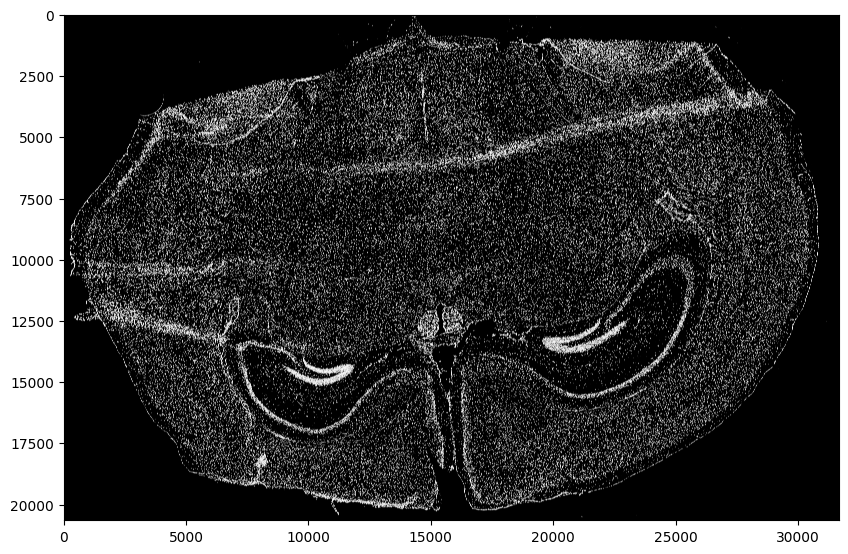

In [9]:
plt.figure(figsize=(10,10),dpi=dpi_set)
plt.imshow(imagej_hyperstack[0:20645, 0:31662], 'gray', interpolation='gaussian')


In [9]:
codebook= np.array(pd.read_csv(path_molecules,header=0, float_precision=None).values)
# get the gene names
gene_pciSeq = codebook[:,2]# [3:,0]


In [10]:
uni_genes_ct = np.unique(gene_pciSeq).shape[0]
uni_genes = np.unique(gene_pciSeq)

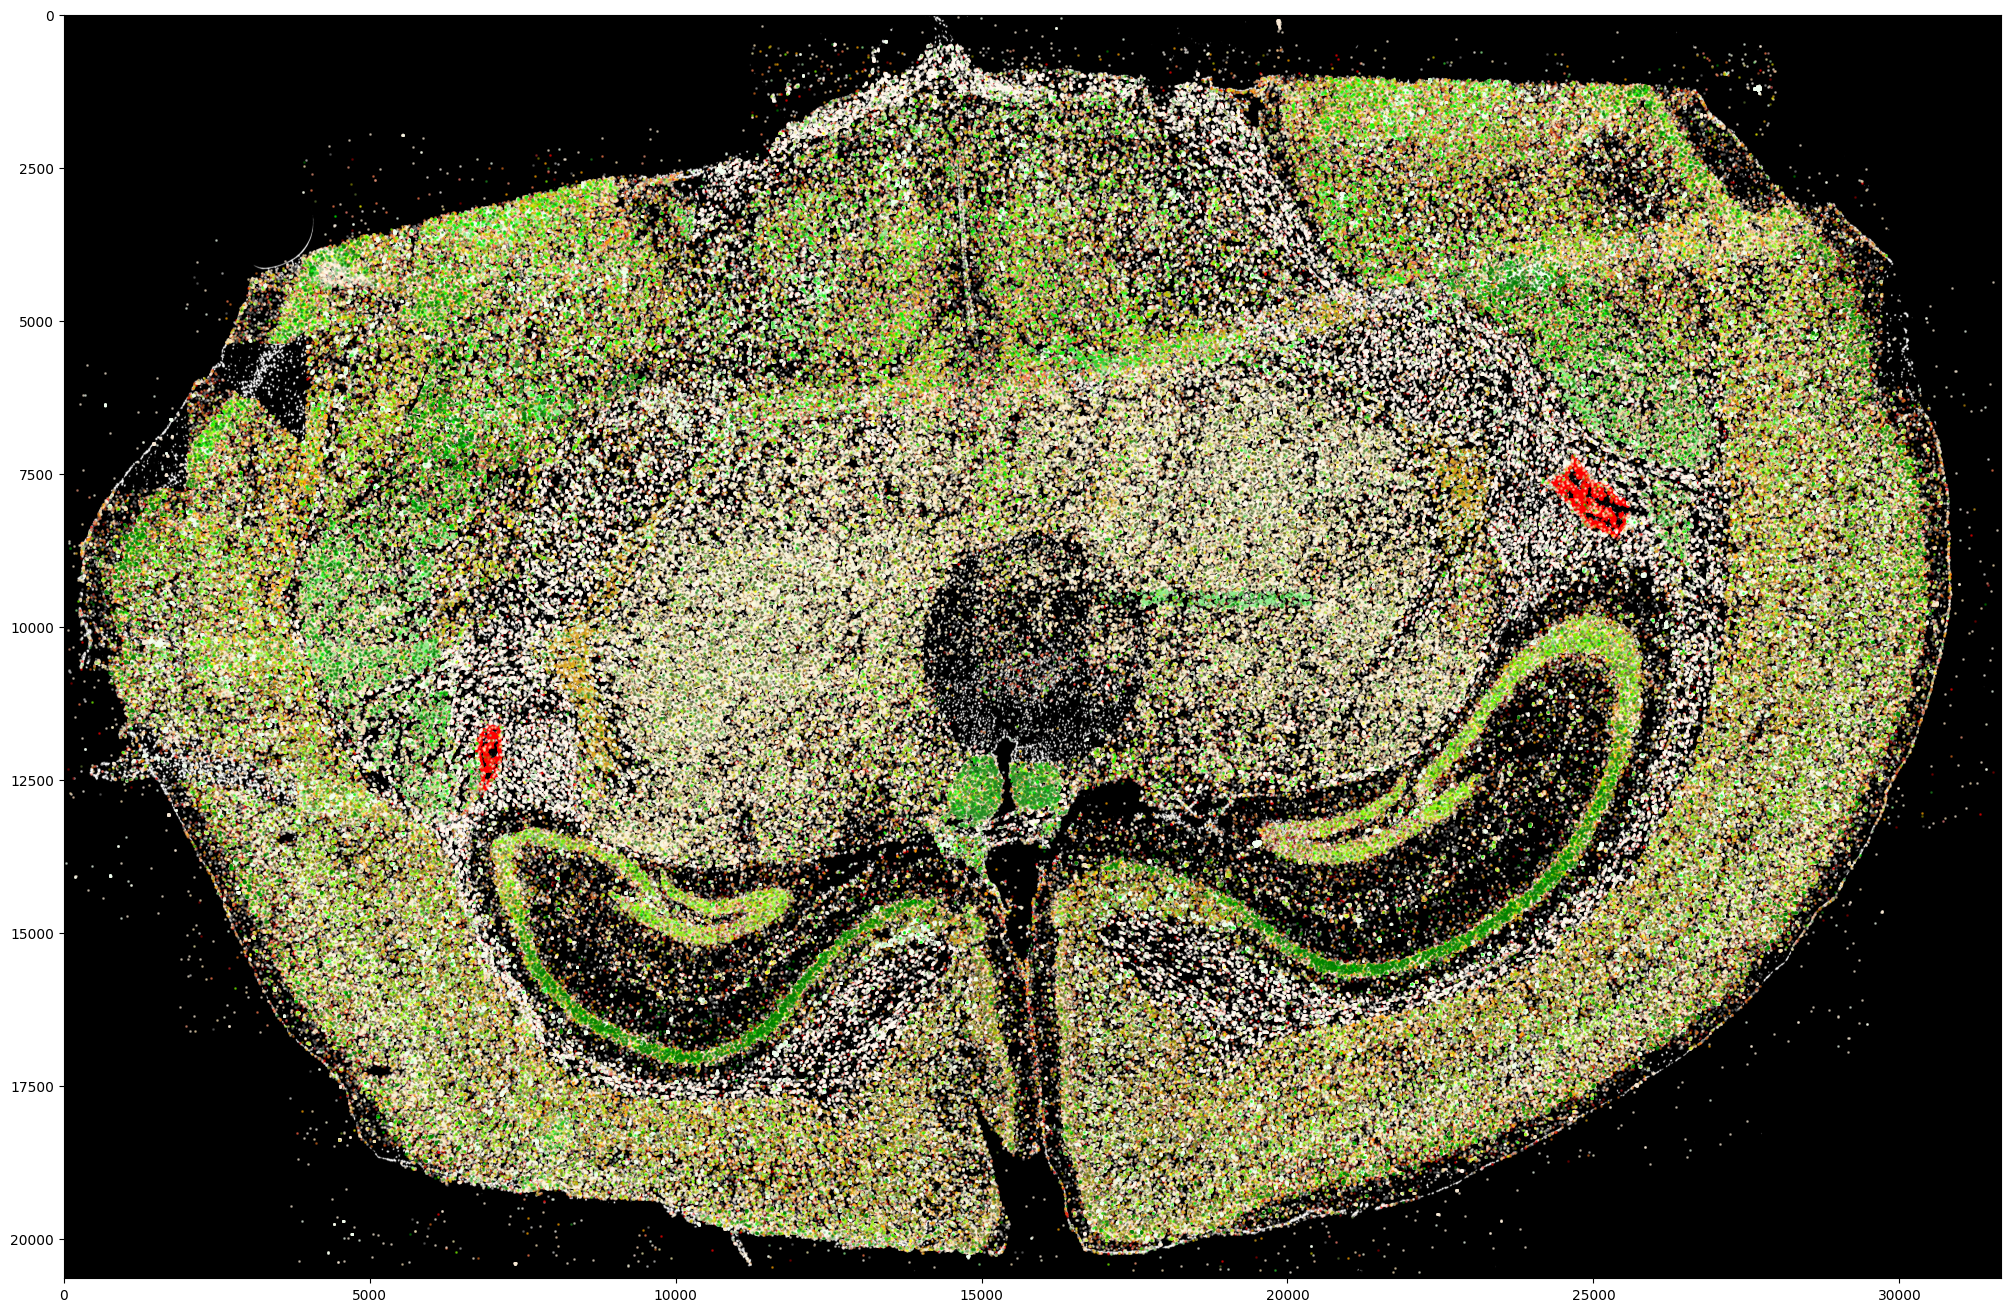

In [12]:
#color=sorted_names[int(gene_id)])

plt.figure(figsize=(25,25),dpi=dpi_set)
plt.imshow(imagej_hyperstack[0:20645, 0:31662], 'gray', interpolation='gaussian')

for i in range(uni_genes_ct):
    genes_id = np.array(np.where(uni_genes[i]==gene_pciSeq)).flatten()
    
    
    plt.plot(codebook[genes_id,1], codebook[genes_id,0],'.',markersize=2, c=sorted_names[int(i)],alpha=0.5)

In [11]:
np.array(np.where(uni_genes[0]==gene_pciSeq)).flatten().shape

(44068,)

In [12]:
uni_genes

array(['3110035E14Rik', 'Adgrl2', 'Aldoc', 'Arpp21', 'Atp1b1', 'Bcl11b',
       'Calb1', 'Calb2', 'Calm2', 'Cck', 'Cdh13', 'Chodl', 'Chrm2',
       'Cnr1', 'Cort', 'Cox6a2', 'Cpne5', 'Crh', 'Crhbp', 'Crym', 'Cux2',
       'Cxcl14', 'Enc1', 'Enpp2', 'Fam19a1', 'Fos', 'Fxyd6', 'Gabrd',
       'Gad1', 'Gap43', 'Gda', 'Grin3a', 'Hapln1', 'Htr3a', 'Id2',
       'Kcnk2', 'Kit', 'Lamp5', 'Lhx6', 'Ndnf', 'Neurod6', 'Nos1', 'Nov',
       'Npy', 'Npy2r', 'Nr4a2', 'Nrn1', 'Pax6', 'Pcp4', 'Pde1a', 'Penk',
       'Plcxd2', 'Plp1', 'Pthlh', 'Pvalb', 'Pvrl3', 'Qrfpr', 'Rab3c',
       'Rasgrf2', 'Reln', 'Rgs10', 'Rgs12', 'Rgs4', 'Rorb', 'Rprm',
       'Satb1', 'Scg2', 'Sema3c', 'Serpini1', 'Slc17a8', 'Slc24a2',
       'Slc6a1', 'Snca', 'Sncg', 'Sst', 'Sulf2', 'Synpr', 'Tac1', 'Tac2',
       'Th', 'Thsd7a', 'Vip', 'Wfs1', 'Zcchc12'], dtype=object)

##  from pciseq codebase

In [20]:
!pip install pciSeq


You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [21]:
import os
import numpy as np
import pandas as pd
import skimage.color
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from scipy.sparse import coo_matrix
import pciSeq
from pciSeq import utils

PyDIPjavaio unavailable:
dlopen(/opt/anaconda3/lib/python3.7/site-packages/diplib/PyDIPjavaio.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libjvm.dylib
  Referenced from: /opt/anaconda3/lib/python3.7/site-packages/diplib/libDIPjavaio.dylib
  Reason: image not found

load_jvm returned '/opt/anaconda3/lib/server/libjvm.dylib'


In [13]:
def GetQHulls(labels):
    Nlabels = labels.max()
    hulls = []
    coords = []
    num_cells = 0
    for i in range(Nlabels): # skip label 0 (background)
        curr_coords = np.argwhere(labels == i)
        if curr_coords.shape[0] < 100000 and curr_coords.shape[0] > 1000:
            num_cells += 1
            hulls.append(ConvexHull(curr_coords))
            coords.append(curr_coords)
    return hulls, coords

### Mesmer segmentation



In [14]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# pip install --ignore-installed --upgrade keras

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#pip install --ignore-installed --upgrade tensorflow

import tensorflow as tf

from scipy import ndimage

from sklearn.manifold import TSNE

import phenograph as pg
from scipy.stats import zscore

from skimage.color import rgb2gray

from matplotlib.patches import Polygon

import matplotlib

Using TensorFlow backend.


In [15]:
!pip install deepcell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 13.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.19.5-cp37-cp37m-macosx_10_

In [16]:
from deepcell.datasets import multiplex_tissue
((X_train, y_train),(X_test, y_test)) = multiplex_tissue.load_data()

ModuleNotFoundError: No module named 'deepcell'